# Plotting some figures 

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sys.path.insert(0, '../../../icenumerics/')
sys.path.insert(0, '../auxnumerics/')
sys.path.insert(0, '../')

import icenumerics as ice
import auxiliary as aux

from parameters import params

%reload_ext autoreload
%autoreload 2

ureg = ice.ureg
idx = pd.IndexSlice

In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'axes.labelsize':20,
})

In [3]:
DATA_PATH = '../../data/test11'
MOUNT_DRIVE = '/home/frieren/BIG/'
MOUNT_DRIVE = '/mnt/BIG/'
PROJECT = 'reentrancy'
DATA_PATH = os.path.join(MOUNT_DRIVE, PROJECT,'test11')
SIZE = 10

# Figure reference

For reference, I want all my figures to be 3.2 in in width since that is the width of a column.

## Vertices counts

In [4]:
# load the csv that has all counts for all total time (omega vals)
# and the complete timeseries
raw_data = pd.read_csv(os.path.join(DATA_PATH,'10','average_counts.csv'),index_col=['field','time'])

# compute the omega values, and theta as well
omega = np.pi/2/raw_data.total_time.to_numpy()

# append omega and theta to the df
raw_data['omega'] = np.around(omega,4)
raw_data['theta'] = raw_data.index.get_level_values('time') * raw_data.omega

In [5]:
data20 = raw_data.xs(20,level='field').reset_index()
max_times = {w:df.time.max() for w,df in data20.groupby('omega')} 
counts = pd.concat(data20.query(f'omega=={w} & time=={t}') for w,t in max_times.items()).sort_values('omega')

## Charge OP
This is precalulated in a script so that I can only read a and plot it

In [6]:
# include the charge OP

# reading data and adding the theta column
kappa = pd.read_csv(os.path.join(DATA_PATH,'10','kappa.csv'))
kappa['theta'] = np.round(kappa.t * np.pi/2/kappa.total_time * 180/np.pi,4)
kappa['kappa'] = np.abs(kappa['kappa'])

# averaging across realizations
avkappa = pd.DataFrame(kappa.groupby(['total_time','theta'])['kappa'].mean()).reset_index()
stdkappa = pd.DataFrame(kappa.groupby(['total_time','theta'])['kappa'].std()).reset_index()

avkappa['omega'] = np.pi/2/avkappa.total_time
stdkappa['omega'] = np.pi/2/stdkappa.total_time

# this is getting the last state for each omega
maxth = {w:df.theta.max() for w,df in avkappa.groupby('omega')} 
final_kappa = pd.concat(
    avkappa.query(f'omega=={w} & theta=={th}') for w,th in maxth.items()).sort_values('omega')

fstd_kappa = pd.concat(
    stdkappa.query(f'omega=={w} & theta=={th}') for w,th in maxth.items()).sort_values('omega')

# normalization
norm_factor = 1/4/params['size']**2 
final_kappa.kappa = final_kappa.kappa * norm_factor
fstd_kappa.kappa = (fstd_kappa.kappa * norm_factor)

##  Chiratity OP

In [8]:
# reading data and adding the theta column
chirs = pd.read_csv(os.path.join(DATA_PATH,'10','chirs.csv'))
chirs['theta'] = np.round(chirs.t * np.pi/2/kappa.total_time * 180/np.pi,4)
chirs['chir'] = np.abs(chirs['chir'])
# averaging across realizations
avchirs = pd.DataFrame(chirs.groupby(['total_time','theta'])['chir'].mean()).reset_index()
avchirs['omega'] = np.pi/2/avchirs.total_time

In [11]:
# this is getting the last state for each omega
maxth = {w:df.theta.max() for w,df in avchirs.groupby('omega')} 
final_chir = pd.concat(
    avchirs.query(f'omega=={w} & theta=={th}') for w,th in maxth.items()).sort_values('omega')
# normalization
final_chir.chir = final_chir.chir / params['size']**2
final_chir

,total_time,theta,chir,omega
33399,1000,89.9955,0.071,0.001571
13399,100,89.9550,0.048,0.015708
11399,90,89.9500,0.045,0.017453
9599,80,89.9438,0.037,0.019635
7999,70,89.9357,0.027,0.022440
6599,50,89.9100,0.038,0.031416
5599,40,89.8875,0.028,0.039270
4799,30,89.8500,0.016,0.052360
4199,20,89.7750,0.007,0.078540
3799,19,89.7632,0.005,0.082673


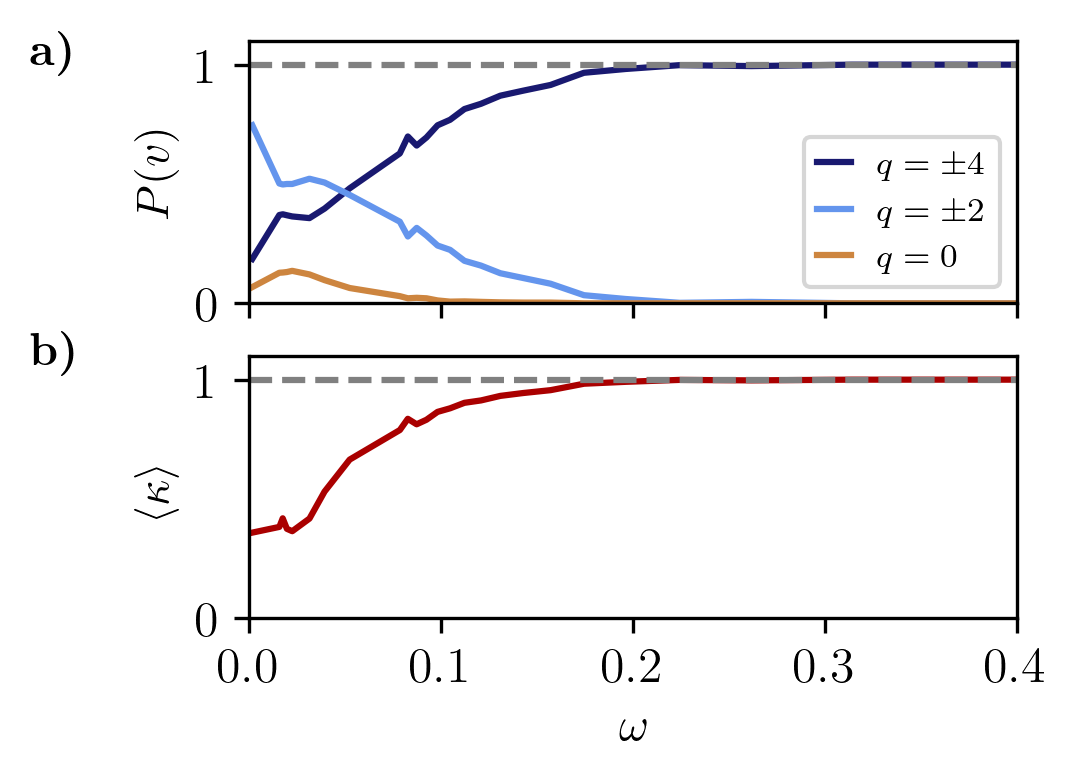

In [49]:
# the figure must be 245.52 total from 3.41 wide
# after saving it crops to 228.447
# so we need to add extra 17.073 pt to compensate, divided by 72
# 1pt = 1/72 in
# that is 0.23 in
COL = 246/72
OFFSET = 17.073/72
#OFFSET = 0

fig, axes = plt.subplots(2,1,figsize=(COL+OFFSET,2.5),dpi=300)
#fig.tight_layout()
#fig.subplots_adjust(hspace=0.1)


#fig = plt.figure(figsize=(3.41+OFFSET, 3),dpi=200)
#gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3, wspace=0.3)
#fig.tight_layout()


types = ['I','II','III','VI','V','VI']
colors = ['#191970', '#6495ed', '#cd853f']

# ==========================================================================================================
# VERTICES COUNTS
# ==========================================================================================================

#ax = fig.add_subplot(gs[0])
ax = axes[0]
ax.plot(counts.omega, counts.I + counts.VI,'-',color=colors[0], label='$q=\\pm 4$')
ax.plot(counts.omega, counts.II + counts.V,'-',color=colors[1], label='$q=\\pm 2$')
ax.plot(counts.omega, counts.III + counts.IV,'-',color=colors[2], label='$q = 0$')
ax.set_xlim(0,0.4)
ax.set_ylim(0,1.1)
ax.set_ylabel('$P(v)$', fontsize=11)
ax.set_xticklabels([])
ax.axhline(1,color='gray',linestyle='--')
ax.legend(fontsize=8,handlelength=1, ncol=1)

# ==========================================================================================================
# ORDER PARAMETERS
# ==========================================================================================================`

#ax = fig.add_subplot(gs[1])
ax = axes[1]
ax.plot(final_kappa.omega, final_kappa.kappa, color='#aa0000', label='$\\kappa$')

ax.set_xlim(0,0.4)
ax.set_ylim(0,1.1)
ax.set_ylabel('$\\langle \\kappa \\rangle$', fontsize=11)
ax.set_xlabel('$\\omega$', fontsize=11)
ax.axhline(1,color='gray',linestyle='--')

# ==========================================================================================================
# LABELS AND OTHER STUFF
# ==========================================================================================================`

fig.subplots_adjust(left=0.2)  # Adjust the bottom space to make room for the shared axis label
fig.text(0,0.85,'\\textbf{a)}',fontsize=11)
fig.text(0,0.45,'\\textbf{b)}',fontsize=11)


plt.show()
fig.savefig('/home/frieren/Dropbox/mnt/martensitepaper/fig3.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
fig.savefig('/home/frieren/Dropbox/mnt/martensitepaper/fig3.png',dpi=300,bbox_inches='tight',pad_inches=0)

#fig.savefig('/home/frieren/Dropbox/mnt/martensitepaper/fig3.pdf',dpi=300)

In [26]:
counts2 = counts.set_index('omega')
c4 = counts2.I + counts2.VI
c2 = counts2.II + counts2.V

In [30]:
c4

omega
0.0016    0.186
0.0157    0.370
0.0175    0.373
0.0196    0.369
0.0224    0.364
0.0314    0.357
0.0393    0.397
0.0524    0.482
0.0785    0.628
0.0827    0.699
0.0873    0.661
0.0924    0.695
0.0982    0.746
0.1047    0.769
0.1122    0.814
0.1208    0.836
0.1309    0.870
0.1428    0.891
0.1571    0.915
0.1745    0.966
0.1963    0.982
0.2244    0.998
0.2618    0.994
0.3142    1.000
0.3927    1.000
0.5236    1.000
0.7854    1.000
1.5708    1.000
dtype: float64